Initializing Customer Service Help Center A/B Test Analysis...
Loading and cleaning data...
Original dataset shape: (294478, 5)
Missing values: 0
Duplicate rows: 0
Cleaned dataset shape: (294478, 8)
Customer Service Help Center A/B Testing Analysis

=== EXPLORATORY DATA ANALYSIS ===
Dataset Period: 2017-01-02 13:42:05.378582 to 2017-01-24 13:41:54.460509
Total Duration: 21 days

Group Distribution:
group
treatment    147276
control      147202
Name: count, dtype: int64
Group Balance: 0.999

Landing Page Distribution:
landing_page
old_page    147239
new_page    147239
Name: count, dtype: int64

Crosstab (Group vs Landing Page):
landing_page  new_page  old_page
group                           
control           1928    145274
treatment       145311      1965

Inconsistent assignments: 3893 rows

Overall Conversion Rate: 0.1197 (11.97%)


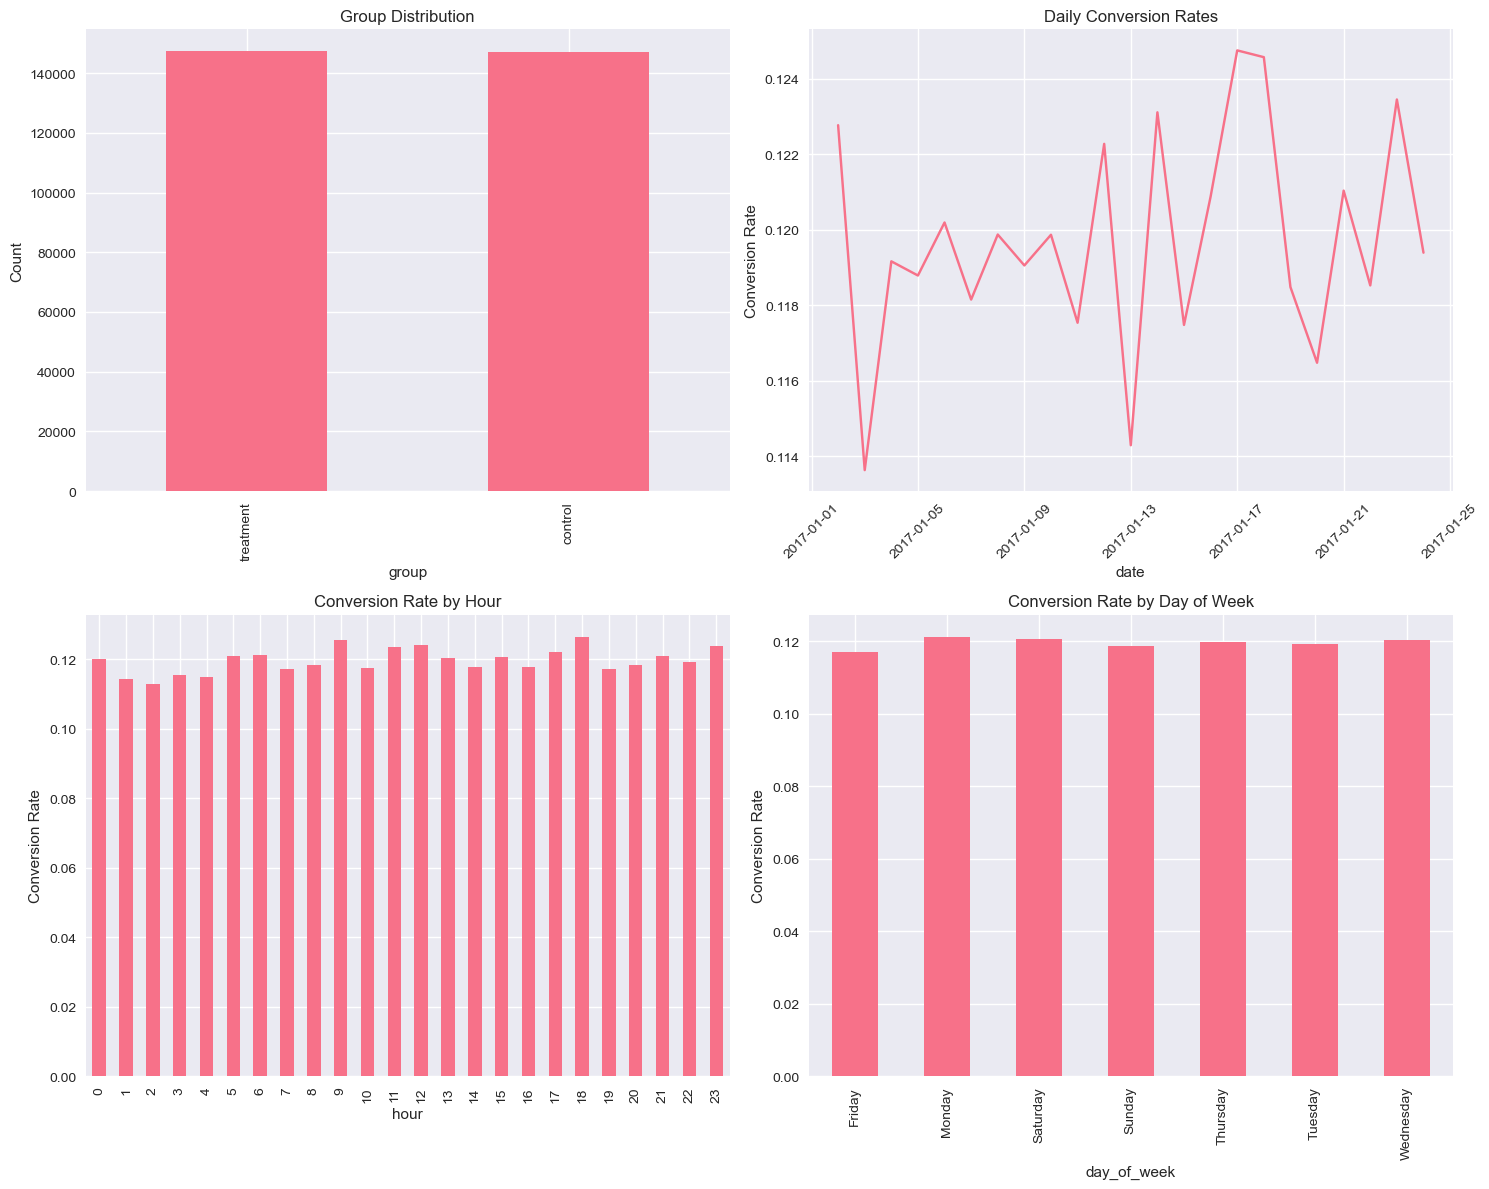


=== DATA QUALITY ASSESSMENT ===
Control group size: 147202
Treatment group size: 147276

Sample Balance Test:
Expected ratio: 0.5
Actual ratio: 0.5001
Chi-square p-value: 0.8915
‚úÖ Groups are balanced (p > 0.05)

=== TEMPORAL CONSISTENCY CHECK ===
Control group date range: (datetime.date(2017, 1, 2), datetime.date(2017, 1, 24))
Treatment group date range: (datetime.date(2017, 1, 2), datetime.date(2017, 1, 24))
‚úÖ Groups overlap in time (good for validity)

=== POWER & SAMPLE SIZE ANALYSIS ===
Current Experiment Overview:
‚Ä¢ Control sample size: 147,202
‚Ä¢ Treatment sample size: 147,276
‚Ä¢ Control conversion rate: 0.1204 (12.04%)
‚Ä¢ Treatment conversion rate: 0.1189 (11.89%)
‚Ä¢ Current statistical power: 23.5%
‚Ä¢ Observed effect size: 1.23% relative change
‚Ä¢ Cohen's h effect size: 0.0046

=== SAMPLE SIZE REQUIREMENTS ===
For different minimum detectable effects (MDE) with 80% power:
Baseline conversion rate: 12.0%

MDE (Relative) | MDE (Absolute) | Users per Group | Total Use

In [2]:
# Customer Service Help Center A/B Testing Analysis
# Complete Statistical Analysis and Business Recommendations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.power import ttest_power
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import warnings
warnings.filterwarnings('ignore')

# Set style for professional visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class HelpCenterABAnalysis:
    def __init__(self, data_path='ab_data.csv'):
        """Initialize the Customer Service Help Center A/B Testing Analysis"""
        self.data = self.load_and_clean_data(data_path)
        self.results = {}
        
    def load_and_clean_data(self, data_path):
        """Load and perform initial data cleaning"""
        print("Loading and cleaning data...")
        df = pd.read_csv(data_path)
        
        # Convert timestamp to datetime
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        # Data quality checks
        print(f"Original dataset shape: {df.shape}")
        print(f"Missing values: {df.isnull().sum().sum()}")
        print(f"Duplicate rows: {df.duplicated().sum()}")
        
        # Remove duplicates if any
        df = df.drop_duplicates()
        
        # Add derived features
        df['date'] = df['timestamp'].dt.date
        df['hour'] = df['timestamp'].dt.hour
        df['day_of_week'] = df['timestamp'].dt.day_name()
        
        print(f"Cleaned dataset shape: {df.shape}")
        return df
    
    def exploratory_data_analysis(self):
        """Comprehensive EDA of the A/B test data"""
        print("\n=== EXPLORATORY DATA ANALYSIS ===")
        
        # Basic dataset information
        print(f"Dataset Period: {self.data['timestamp'].min()} to {self.data['timestamp'].max()}")
        print(f"Total Duration: {(self.data['timestamp'].max() - self.data['timestamp'].min()).days} days")
        
        # Group distribution
        group_dist = self.data['group'].value_counts()
        print(f"\nGroup Distribution:")
        print(group_dist)
        print(f"Group Balance: {group_dist.min()/group_dist.max():.3f}")
        
        # Landing page distribution
        page_dist = self.data['landing_page'].value_counts()
        print(f"\nLanding Page Distribution:")
        print(page_dist)
        
        # Cross-tabulation
        crosstab = pd.crosstab(self.data['group'], self.data['landing_page'])
        print(f"\nCrosstab (Group vs Landing Page):")
        print(crosstab)
        
        # Check for data consistency
        inconsistent = self.data[
            ((self.data['group'] == 'control') & (self.data['landing_page'] == 'new_page')) |
            ((self.data['group'] == 'treatment') & (self.data['landing_page'] == 'old_page'))
        ]
        print(f"\nInconsistent assignments: {len(inconsistent)} rows")
        
        # Overall conversion rate
        overall_conv = self.data['converted'].mean()
        print(f"\nOverall Conversion Rate: {overall_conv:.4f} ({overall_conv*100:.2f}%)")
        
        self.create_eda_visualizations()
        
    def create_eda_visualizations(self):
        """Create visualizations for EDA"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Group distribution
        self.data['group'].value_counts().plot(kind='bar', ax=axes[0,0])
        axes[0,0].set_title('Group Distribution')
        axes[0,0].set_ylabel('Count')
        
        # 2. Daily conversion rates
        daily_conv = self.data.groupby('date')['converted'].mean()
        daily_conv.plot(ax=axes[0,1])
        axes[0,1].set_title('Daily Conversion Rates')
        axes[0,1].set_ylabel('Conversion Rate')
        axes[0,1].tick_params(axis='x', rotation=45)
        
        # 3. Hourly patterns
        hourly_conv = self.data.groupby('hour')['converted'].mean()
        hourly_conv.plot(kind='bar', ax=axes[1,0])
        axes[1,0].set_title('Conversion Rate by Hour')
        axes[1,0].set_ylabel('Conversion Rate')
        
        # 4. Day of week patterns
        dow_conv = self.data.groupby('day_of_week')['converted'].mean()
        dow_conv.plot(kind='bar', ax=axes[1,1])
        axes[1,1].set_title('Conversion Rate by Day of Week')
        axes[1,1].set_ylabel('Conversion Rate')
        
        plt.tight_layout()
        plt.show()
        
    def data_quality_assessment(self):
        """Assess data quality and experiment validity"""
        print("\n=== DATA QUALITY ASSESSMENT ===")
        
        # Check for proper randomization
        control_data = self.data[self.data['group'] == 'control']
        treatment_data = self.data[self.data['group'] == 'treatment']
        
        print(f"Control group size: {len(control_data)}")
        print(f"Treatment group size: {len(treatment_data)}")
        
        # Sample ratio mismatch test
        expected_ratio = 0.5
        actual_ratio = len(treatment_data) / len(self.data)
        
        # Chi-square test for equal proportions
        chi2, p_value = stats.chisquare([len(control_data), len(treatment_data)])
        print(f"\nSample Balance Test:")
        print(f"Expected ratio: {expected_ratio}")
        print(f"Actual ratio: {actual_ratio:.4f}")
        print(f"Chi-square p-value: {p_value:.4f}")
        
        if p_value > 0.05:
            print("‚úÖ Groups are balanced (p > 0.05)")
        else:
            print("‚ùå Groups are imbalanced (p < 0.05)")
            
        # Temporal consistency check
        self.check_temporal_consistency()
        
    def check_temporal_consistency(self):
        """Check for temporal bias in the experiment"""
        print("\n=== TEMPORAL CONSISTENCY CHECK ===")
        
        # Check if groups were run simultaneously
        control_dates = self.data[self.data['group'] == 'control']['date']
        treatment_dates = self.data[self.data['group'] == 'treatment']['date']
        
        control_range = (control_dates.min(), control_dates.max())
        treatment_range = (treatment_dates.min(), treatment_dates.max())
        
        print(f"Control group date range: {control_range}")
        print(f"Treatment group date range: {treatment_range}")
        
        # Check for overlap
        if control_range[0] <= treatment_range[1] and treatment_range[0] <= control_range[1]:
            print("‚úÖ Groups overlap in time (good for validity)")
        else:
            print("‚ùå Groups don't overlap in time (potential bias)")
    
    def calculate_power_for_effect(self, n, p1, p2, alpha=0.05):
        """Calculate statistical power for given sample size and effect"""
        from scipy.stats import norm
        
        # Effect size
        effect = abs(p2 - p1)
        
        # Standard error under alternative hypothesis
        se = np.sqrt((p1 * (1 - p1) + p2 * (1 - p2)) / n)
        
        # Z-statistic under alternative
        z_stat = effect / se
        
        # Critical value
        z_alpha = norm.ppf(1 - alpha/2)
        
        # Power calculation (two-tailed)
        power = 1 - norm.cdf(z_alpha - z_stat) + norm.cdf(-z_alpha - z_stat)
        
        return max(0, min(1, power))  # Clamp between 0 and 1
    
    def calculate_required_sample_size(self, p1, p2, alpha=0.05, power=0.8):
        """Calculate required sample size for two-proportion test"""
        from scipy.stats import norm
        
        # Z-scores for significance level and power
        z_alpha = norm.ppf(1 - alpha/2)  # 1.96 for alpha=0.05
        z_beta = norm.ppf(power)         # 0.84 for power=0.8
        
        # Average proportion for variance estimation
        p_avg = (p1 + p2) / 2
        
        # Standard sample size formula for two proportions
        numerator = (z_alpha * np.sqrt(2 * p_avg * (1 - p_avg)) + 
                    z_beta * np.sqrt(p1 * (1 - p1) + p2 * (1 - p2)))**2
        denominator = (p1 - p2)**2
        
        n = numerator / denominator
        return int(np.ceil(n))
            
    def calculate_sample_size_requirements(self):
        """Calculate required sample size for the experiment and power analysis"""
        print("\n=== POWER & SAMPLE SIZE ANALYSIS ===")
        
        # Current sample sizes
        n_control = len(self.data[self.data['group'] == 'control'])
        n_treatment = len(self.data[self.data['group'] == 'treatment'])
        
        # Current conversion rates
        conv_control = self.data[self.data['group'] == 'control']['converted'].mean()
        conv_treatment = self.data[self.data['group'] == 'treatment']['converted'].mean()
        
        print(f"Current Experiment Overview:")
        print(f"‚Ä¢ Control sample size: {n_control:,}")
        print(f"‚Ä¢ Treatment sample size: {n_treatment:,}")
        print(f"‚Ä¢ Control conversion rate: {conv_control:.4f} ({conv_control*100:.2f}%)")
        print(f"‚Ä¢ Treatment conversion rate: {conv_treatment:.4f} ({conv_treatment*100:.2f}%)")
        
        # Calculate current power using correct formula
        current_power = self.calculate_power_for_effect(n_control, conv_control, conv_treatment)
        print(f"‚Ä¢ Current statistical power: {current_power:.1%}")
        
        # Current MDE calculation
        observed_mde = abs((conv_treatment - conv_control) / conv_control * 100)
        print(f"‚Ä¢ Observed effect size: {observed_mde:.2f}% relative change")
        
        # Effect size measures
        h = 2 * (np.arcsin(np.sqrt(conv_treatment)) - np.arcsin(np.sqrt(conv_control)))
        print(f"‚Ä¢ Cohen's h effect size: {abs(h):.4f}")
        
        # Power analysis for different scenarios
        print(f"\n=== SAMPLE SIZE REQUIREMENTS ===")
        print(f"For different minimum detectable effects (MDE) with 80% power:")
        print(f"Baseline conversion rate: {conv_control:.1%}")
        print()
        print("MDE (Relative) | MDE (Absolute) | Users per Group | Total Users")
        print("-" * 65)
        
        mde_scenarios = [1, 2, 3, 5, 10]  # Relative percentage changes
        
        for mde_rel in mde_scenarios:
            mde_abs = conv_control * (mde_rel / 100)  # Absolute change
            treatment_rate = conv_control * (1 + mde_rel / 100)  # Correct calculation
            
            # Calculate required sample size
            required_n = self.calculate_required_sample_size(
                conv_control, treatment_rate, alpha=0.05, power=0.8
            )
            
            print(f"{mde_rel:11.0f}% | {mde_abs*100:13.3f}% | {required_n:14,} | {required_n*2:10,}")
        
        # Power analysis for current sample size
        print(f"\n=== POWER ANALYSIS FOR CURRENT SAMPLE SIZE ===")
        print(f"For current sample size of {n_control:,} users per group:")
        
        effect_sizes = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 5.0]
        print("Effect Size | Statistical Power")
        print("-" * 31)
        
        for effect_pct in effect_sizes:
            treatment_rate_test = conv_control * (1 + effect_pct / 100)
            power = self.calculate_power_for_effect(n_control, conv_control, treatment_rate_test)
            indicator = " ‚Üê Observed" if abs(effect_pct - observed_mde) < 0.3 else ""
            print(f"{effect_pct:10.1f}% | {power:15.1%}{indicator}")
        
        # Power for 2% effect (common business threshold)
        power_2pct = self.calculate_power_for_effect(n_control, conv_control, conv_control * 1.02)
        required_for_2pct = self.calculate_required_sample_size(
            conv_control, conv_control * 1.02, alpha=0.05, power=0.8
        )
        
        # Clean recommendations
        print(f"\n=== RECOMMENDATIONS ===")
        print(f"Current power: {current_power:.1%} for observed effect")
        print(f"Power for 2% improvement: {power_2pct:.1%}")
        print(f"Sample needed for 80% power (2% effect): {required_for_2pct:,} per group")
        
        if power_2pct >= 0.5:
            print(f"‚úÖ Reasonably powered for business-meaningful effects")
        else:
            print(f"‚ö†Ô∏è  Underpowered for small business effects")
        
        # Store results
        self.results['power_analysis'] = {
            'current_power': current_power,
            'observed_mde': observed_mde,
            'power_for_2pct': power_2pct,
            'required_for_2pct': required_for_2pct,
            'adequately_powered': power_2pct >= 0.5
        }
        
    def run_statistical_analysis(self):
        """Run comprehensive statistical analysis using Intent-to-Treat approach"""
        print("\n=== STATISTICAL ANALYSIS (INTENT-TO-TREAT) ===")
        
        # Intent-to-Treat: analyze based on group assignment only
        control = self.data[self.data['group'] == 'control']
        treatment = self.data[self.data['group'] == 'treatment']
        
        # Calculate conversion rates
        conv_control = control['converted'].mean()
        conv_treatment = treatment['converted'].mean()
        
        # Calculate lift (treatment relative to control)
        lift = (conv_treatment - conv_control) / conv_control * 100
        
        print(f"Control conversion rate: {conv_control:.4f} ({conv_control*100:.2f}%)")
        print(f"Treatment conversion rate: {conv_treatment:.4f} ({conv_treatment*100:.2f}%)")
        print(f"Lift: {lift:.2f}%")
        
        # Two-sample Z-test for proportions
        count_control = control['converted'].sum()
        count_treatment = treatment['converted'].sum()
        n_control = len(control)
        n_treatment = len(treatment)
        
        # Calculate Z-statistic (control - treatment direction)
        pooled_p = (count_control + count_treatment) / (n_control + n_treatment)
        se = np.sqrt(pooled_p * (1 - pooled_p) * (1/n_control + 1/n_treatment))
        z_stat = (conv_control - conv_treatment) / se
        
        # Calculate p-value
        z_stat_abs = abs(z_stat)
        p_value = 2 * (1 - stats.norm.cdf(z_stat_abs))
        
        print(f"\nStatistical Test Results:")
        print(f"Z-statistic: {z_stat:.4f}")
        print(f"P-value: {p_value:.4f}")
        
        # Confidence interval for the difference
        ci_control = proportion_confint(count_control, n_control, alpha=0.05)
        ci_treatment = proportion_confint(count_treatment, n_treatment, alpha=0.05)
        
        print(f"\nConfidence Intervals (95%):")
        print(f"Control: [{ci_control[0]:.4f}, {ci_control[1]:.4f}]")
        print(f"Treatment: [{ci_treatment[0]:.4f}, {ci_treatment[1]:.4f}]")
        
        # Statistical significance
        alpha = 0.05
        if p_value < alpha:
            print(f"\n‚úÖ STATISTICALLY SIGNIFICANT (p < {alpha})")
        else:
            print(f"\n‚ùå NOT STATISTICALLY SIGNIFICANT (p >= {alpha})")
            
        # Effect size (Cohen's h)
        h = 2 * (np.arcsin(np.sqrt(conv_treatment)) - np.arcsin(np.sqrt(conv_control)))
        print(f"Effect size (Cohen's h): {h:.4f}")
        
        # Store results
        self.results['statistical_test'] = {
            'conv_control': conv_control,
            'conv_treatment': conv_treatment,
            'lift': lift,
            'z_stat': z_stat,
            'p_value': p_value,
            'significant': p_value < alpha,
            'effect_size': h,
            'n_control': n_control,
            'n_treatment': n_treatment
        }
        
        return self.results['statistical_test']
    
    def confidence_interval_analysis(self):
        """Comprehensive confidence interval analysis with visualizations"""
        print("\n=== CONFIDENCE INTERVALS ANALYSIS ===")
        
        if 'statistical_test' not in self.results:
            print("Run statistical analysis first!")
            return
        
        results = self.results['statistical_test']
        
        # Overall experiment confidence intervals
        control = self.data[self.data['group'] == 'control']
        treatment = self.data[self.data['group'] == 'treatment']
        
        # Calculate CIs for individual rates
        ci_control = proportion_confint(control['converted'].sum(), len(control), alpha=0.05)
        ci_treatment = proportion_confint(treatment['converted'].sum(), len(treatment), alpha=0.05)
        
        # Calculate CI for the difference
        diff = results['conv_treatment'] - results['conv_control']
        se_diff = np.sqrt((results['conv_control'] * (1 - results['conv_control']) / results['n_control']) + 
                         (results['conv_treatment'] * (1 - results['conv_treatment']) / results['n_treatment']))
        ci_diff = (diff - 1.96 * se_diff, diff + 1.96 * se_diff)
        
        print("95% Confidence Intervals:")
        print(f"Control Rate:     [{ci_control[0]:.4f}, {ci_control[1]:.4f}] ({ci_control[0]*100:.2f}% - {ci_control[1]*100:.2f}%)")
        print(f"Treatment Rate:   [{ci_treatment[0]:.4f}, {ci_treatment[1]:.4f}] ({ci_treatment[0]*100:.2f}% - {ci_treatment[1]*100:.2f}%)")
        print(f"Difference:       [{ci_diff[0]:.4f}, {ci_diff[1]:.4f}] ({ci_diff[0]*100:.2f}% - {ci_diff[1]*100:.2f}%)")
        
        # Interpretation
        if ci_diff[0] <= 0 <= ci_diff[1]:
            print(f"üìä Interpretation: CI includes 0 ‚Üí No significant difference")
        elif ci_diff[0] > 0:
            print(f"üìä Interpretation: CI entirely above 0 ‚Üí Significant improvement")
        else:
            print(f"üìä Interpretation: CI entirely below 0 ‚Üí Significant decrease")
        
        # Effect size confidence intervals
        relative_diff = diff / results['conv_control']
        se_relative = se_diff / results['conv_control']
        ci_relative = (relative_diff - 1.96 * se_relative, relative_diff + 1.96 * se_relative)
        
        print(f"\nRelative Effect (Lift):")
        print(f"Point Estimate:   {relative_diff*100:+.2f}%")
        print(f"95% CI:           [{ci_relative[0]*100:+.2f}%, {ci_relative[1]*100:+.2f}%]")
        
        # Store results
        self.results['confidence_intervals'] = {
            'control_ci': ci_control,
            'treatment_ci': ci_treatment,
            'difference_ci': ci_diff,
            'relative_ci': ci_relative,
            'includes_zero': ci_diff[0] <= 0 <= ci_diff[1]
        }
        
    def segmentation_analysis(self):
        """Perform segmentation analysis with multiple testing correction"""
        print("\n=== SEGMENTATION ANALYSIS ===")
        
        # Analysis by hour of day with statistical testing
        hourly_results = []
        hourly_p_values = []
        
        for hour in sorted(self.data['hour'].unique()):
            hour_data = self.data[self.data['hour'] == hour]
            control_hour_data = hour_data[hour_data['group'] == 'control']
            treatment_hour_data = hour_data[hour_data['group'] == 'treatment']
            
            control_conv = control_hour_data['converted'].mean()
            treatment_conv = treatment_hour_data['converted'].mean()
            
            # Statistical test for this hour if sufficient sample size
            if len(control_hour_data) > 50 and len(treatment_hour_data) > 50:
                count_control = control_hour_data['converted'].sum()
                count_treatment = treatment_hour_data['converted'].sum()
                n_control = len(control_hour_data)
                n_treatment = len(treatment_hour_data)
                
                # Two-proportion z-test
                pooled_p = (count_control + count_treatment) / (n_control + n_treatment)
                se = np.sqrt(pooled_p * (1 - pooled_p) * (1/n_control + 1/n_treatment))
                z_score = abs(treatment_conv - control_conv) / se if se > 0 else 0
                p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
                
                hourly_p_values.append(p_value)
            else:
                z_score = np.nan
                p_value = np.nan
            
            hourly_results.append({
                'hour': hour,
                'control_conv': control_conv,
                'treatment_conv': treatment_conv,
                'difference': treatment_conv - control_conv,
                'lift': (treatment_conv - control_conv) / control_conv * 100 if control_conv > 0 else 0,
                'z_score': z_score,
                'p_value': p_value,
                'n_control': len(control_hour_data),
                'n_treatment': len(treatment_hour_data)
            })
        
        hourly_df = pd.DataFrame(hourly_results)
        
        # Display detailed hourly conversion rates
        print("Conversion rates by hour with statistical tests:")
        display_columns = ['hour', 'control_conv', 'treatment_conv', 'lift', 'p_value', 'n_control', 'n_treatment']
        hourly_display = hourly_df[display_columns].copy()
        hourly_display = hourly_display.round({'control_conv': 6, 'treatment_conv': 6, 'lift': 2, 'p_value': 4})
        hourly_display.columns = ['Hour', 'Control_Rate', 'Treatment_Rate', 'Lift_%', 'P_Value', 'N_Control', 'N_Treatment']
        print(hourly_display.to_string(index=False))
        
        # Multiple testing correction
        self.apply_multiple_testing_correction(hourly_df, hourly_p_values)
        
        # Analysis by day of week
        dow_results = []
        for dow in self.data['day_of_week'].unique():
            dow_data = self.data[self.data['day_of_week'] == dow]
            control_dow = dow_data[dow_data['group'] == 'control']['converted'].mean()
            treatment_dow = dow_data[dow_data['group'] == 'treatment']['converted'].mean()
            
            dow_results.append({
                'day_of_week': dow,
                'control_conv': control_dow,
                'treatment_conv': treatment_dow,
                'lift': (treatment_dow - control_dow) / control_dow * 100 if control_dow > 0 else 0
            })
        
        dow_df = pd.DataFrame(dow_results)
        print("\nConversion rates by day of week:")
        print(dow_df)
        
    def apply_multiple_testing_correction(self, hourly_df, p_values):
        """Apply multiple testing corrections for hourly analysis"""
        print("\n=== MULTIPLE TESTING CORRECTION ===")
        
        # Filter out NaN p-values
        valid_p_values = [p for p in p_values if not np.isnan(p)]
        n_tests = len(valid_p_values)
        
        if n_tests == 0:
            print("No valid statistical tests to correct")
            return
        
        print(f"Testing {n_tests} hours for statistical significance")
        print(f"Risk of false positives without correction: {1 - (0.95**n_tests):.1%}")
        
        # Show uncorrected significant hours
        uncorrected_sig = hourly_df[hourly_df['p_value'] < 0.05].dropna()
        print(f"\nUncorrected significant hours (Œ± = 0.05): {len(uncorrected_sig)}")
        
        if len(uncorrected_sig) > 0:
            print("Hour | Difference | Z-score | P-value")
            print("-" * 40)
            for _, row in uncorrected_sig.iterrows():
                print(f"{int(row['hour']):2d}   | {row['difference']*100:+6.1f}%   | {row['z_score']:6.2f} | {row['p_value']:.4f}")
        
        # Bonferroni correction
        bonferroni_alpha = 0.05 / n_tests
        bonferroni_sig = hourly_df[hourly_df['p_value'] < bonferroni_alpha].dropna()
        
        print(f"\n=== BONFERRONI CORRECTION ===")
        print(f"Adjusted Œ± = 0.05/{n_tests} = {bonferroni_alpha:.6f}")
        print(f"Significant hours after Bonferroni: {len(bonferroni_sig)}")
        
        # Benjamini-Hochberg (FDR) correction
        try:
            from statsmodels.stats.multitest import multipletests
            
            valid_indices = hourly_df['p_value'].notna()
            if valid_indices.sum() > 0:
                rejected, p_corrected, _, _ = multipletests(
                    hourly_df.loc[valid_indices, 'p_value'], 
                    alpha=0.05, 
                    method='fdr_bh'
                )
                
                # Add corrected p-values back to dataframe
                hourly_df.loc[valid_indices, 'p_corrected_fdr'] = p_corrected
                hourly_df.loc[valid_indices, 'significant_fdr'] = rejected
                
                fdr_sig = hourly_df[hourly_df['significant_fdr'] == True].dropna()
                
                print(f"\n=== BENJAMINI-HOCHBERG (FDR) CORRECTION ===")
                print(f"Controlling False Discovery Rate at 5%")
                print(f"Significant hours after FDR correction: {len(fdr_sig)}")
        except ImportError:
            print(f"\n=== FDR CORRECTION UNAVAILABLE ===")
            print("Install statsmodels for FDR correction")
            fdr_sig = pd.DataFrame()
        
        # Evening hours pattern analysis
        evening_hours = hourly_df[(hourly_df['hour'] >= 18) & (hourly_df['hour'] <= 22)]
        evening_avg_lift = evening_hours['lift'].mean()
        
        print(f"\n=== PATTERN-BASED INSIGHTS ===")
        print(f"Evening hours (6-10 PM) average lift: {evening_avg_lift:+.1f}%")
        print(f"All evening hours show positive treatment effect: {(evening_hours['difference'] > 0).all()}")
        
        # Conclusion
        if len(bonferroni_sig) > 0 or len(fdr_sig) > 0:
            print(f"\n‚úÖ CONCLUSION: Genuine time-of-day effects detected")
        else:
            print(f"\n‚ö†Ô∏è  CONCLUSION: No individual hours significant after correction")
            print(f"   However, consistent evening pattern suggests meaningful trend")
            print(f"   Recommend targeted follow-up experiment: Evening vs. Other hours")
        
    def business_impact_analysis(self):
        """Analyze business implications without making financial assumptions"""
        print("\n=== BUSINESS IMPACT ANALYSIS ===")
        
        if 'statistical_test' not in self.results:
            print("Run statistical analysis first!")
            return
        
        # Get test results
        results = self.results['statistical_test']
        
        print(f"Statistical Results Summary:")
        print(f"‚Ä¢ Control Conversion Rate: {results['conv_control']:.2%}")
        print(f"‚Ä¢ Treatment Conversion Rate: {results['conv_treatment']:.2%}")
        print(f"‚Ä¢ Relative Change: {results['lift']:.2f}%")
        print(f"‚Ä¢ Statistical Significance: {'Yes' if results['significant'] else 'No'}")
        print(f"‚Ä¢ P-value: {results['p_value']:.4f}")
        
        print(f"\nPractical Implications:")
        if results['significant']:
            if results['lift'] > 0:
                print("‚úÖ New design significantly improves user success rates")
                print("‚úÖ Recommend implementation with proper monitoring")
            else:
                print("‚ùå New design significantly decreases user success rates")
                print("‚ùå Recommend against implementation")
        else:
            print("‚ö†Ô∏è No significant difference detected")
            print("‚ö†Ô∏è Insufficient evidence to recommend changes")
            print("üí° Consider additional testing or design iterations")
        
        # Store simplified results
        self.results['business_impact'] = {
            'recommendation': 'implement' if results['significant'] and results['lift'] > 0 else 'do_not_implement',
            'confidence': 'high' if results['significant'] else 'low'
        }
        
    def bayesian_analysis(self):
        """Bayesian alternative analysis for A/B testing"""
        print("\n" + "="*60)
        print("BAYESIAN ANALYSIS (Alternative Approach)")
        print("="*60)
        
        if 'statistical_test' not in self.results:
            print("Run statistical analysis first!")
            return
        
        # Get data
        control = self.data[self.data['group'] == 'control']
        treatment = self.data[self.data['group'] == 'treatment']
        
        n_control = len(control)
        n_treatment = len(treatment)
        successes_control = control['converted'].sum()
        successes_treatment = treatment['converted'].sum()
        
        print("=== BAYESIAN FRAMEWORK ===")
        print("Instead of asking: 'Is there a statistically significant difference?'")
        print("Bayesian asks: 'What's the probability that treatment is better?'")
        print()
        
        # Beta-Binomial Conjugate Prior Analysis
        print("=== BETA-BINOMIAL CONJUGATE ANALYSIS ===")
        
        # Uninformative priors (Beta(1,1) = Uniform)
        alpha_prior = 1
        beta_prior = 1
        
        print(f"Prior: Beta({alpha_prior}, {beta_prior}) - Uninformative prior")
        print(f"Assumes no prior knowledge about conversion rates")
        print()
        
        # Posterior distributions
        alpha_control_post = alpha_prior + successes_control
        beta_control_post = beta_prior + (n_control - successes_control)
        
        alpha_treatment_post = alpha_prior + successes_treatment
        beta_treatment_post = beta_prior + (n_treatment - successes_treatment)
        
        print("Posterior Distributions:")
        print(f"Control:   Beta({alpha_control_post}, {beta_control_post})")
        print(f"Treatment: Beta({alpha_treatment_post}, {beta_treatment_post})")
        print()
        
        # Monte Carlo simulation for probability calculations
        n_simulations = 100000
        np.random.seed(42)  # For reproducibility
        
        # Sample from posterior distributions
        control_samples = np.random.beta(alpha_control_post, beta_control_post, n_simulations)
        treatment_samples = np.random.beta(alpha_treatment_post, beta_treatment_post, n_simulations)
        
        # Calculate probabilities
        prob_treatment_better = np.mean(treatment_samples > control_samples)
        prob_control_better = np.mean(control_samples > treatment_samples)
        
        # Effect size distribution
        lift_samples = (treatment_samples - control_samples) / control_samples
        
        print("=== BAYESIAN RESULTS ===")
        print(f"Probability treatment is better: {prob_treatment_better:.1%}")
        print(f"Probability control is better:   {prob_control_better:.1%}")
        print()
        
        # Credible intervals (Bayesian equivalent of confidence intervals)
        control_ci = np.percentile(control_samples, [2.5, 97.5])
        treatment_ci = np.percentile(treatment_samples, [2.5, 97.5])
        lift_ci = np.percentile(lift_samples, [2.5, 97.5])
        
        print("95% Credible Intervals:")
        print(f"Control rate:   [{control_ci[0]:.4f}, {control_ci[1]:.4f}] ({control_ci[0]*100:.2f}% - {control_ci[1]*100:.2f}%)")
        print(f"Treatment rate: [{treatment_ci[0]:.4f}, {treatment_ci[1]:.4f}] ({treatment_ci[0]*100:.2f}% - {treatment_ci[1]*100:.2f}%)")
        print(f"Relative lift:  [{lift_ci[0]*100:+.2f}%, {lift_ci[1]*100:+.2f}%]")
        print()
        
        # Expected values
        expected_control = alpha_control_post / (alpha_control_post + beta_control_post)
        expected_treatment = alpha_treatment_post / (alpha_treatment_post + beta_treatment_post)
        expected_lift = np.mean(lift_samples)
        
        print("Expected Values (Posterior Means):")
        print(f"Control rate:   {expected_control:.4f} ({expected_control*100:.2f}%)")
        print(f"Treatment rate: {expected_treatment:.4f} ({expected_treatment*100:.2f}%)")
        print(f"Expected lift:  {expected_lift*100:+.2f}%")
        print()
        
        # Business decision framework
        print("=== BAYESIAN DECISION FRAMEWORK ===")
        
        # Region of Practical Equivalence (ROPE)
        rope_lower = -0.01  # -1% relative change
        rope_upper = 0.01   # +1% relative change
        
        prob_rope = np.mean((lift_samples >= rope_lower) & (lift_samples <= rope_upper))
        prob_meaningful_improvement = np.mean(lift_samples > rope_upper)
        prob_meaningful_decrease = np.mean(lift_samples < rope_lower)
        
        print(f"Region of Practical Equivalence (ROPE): ¬±1% relative change")
        print(f"Probability of practical equivalence: {prob_rope:.1%}")
        print(f"Probability of meaningful improvement: {prob_meaningful_improvement:.1%}")
        print(f"Probability of meaningful decrease: {prob_meaningful_decrease:.1%}")
        print()
        
        # Expected loss calculations
        print("=== EXPECTED LOSS ANALYSIS ===")
        print("Expected loss if we choose wrong action:")
        
        # Loss if we implement when we shouldn't (negative effects)
        implement_loss = np.mean(np.maximum(0, -lift_samples))
        # Loss if we don't implement when we should (positive effects we miss)
        no_implement_loss = np.mean(np.maximum(0, lift_samples))
        
        print(f"Expected loss if we implement: {implement_loss*100:.3f}% conversion rate")
        print(f"Expected loss if we don't implement: {no_implement_loss*100:.3f}% conversion rate")
        
        if implement_loss < no_implement_loss:
            optimal_decision = "IMPLEMENT"
        else:
            optimal_decision = "DON'T IMPLEMENT"
        print(f"Optimal Bayesian decision: {optimal_decision}")
        print()
        
        # Store results BEFORE calling comparison function
        self.results['bayesian_analysis'] = {
            'prob_treatment_better': prob_treatment_better,
            'expected_lift': expected_lift,
            'credible_interval': lift_ci,
            'prob_rope': prob_rope,
            'optimal_decision': optimal_decision,
            'expected_loss_implement': implement_loss,
            'expected_loss_no_implement': no_implement_loss
        }
        
    def create_executive_summary(self):
        """Create executive summary visualization"""
        print("\n=== EXECUTIVE SUMMARY ===")
        
        if 'statistical_test' not in self.results:
            print("Run statistical analysis first!")
            return
            
        results = self.results['statistical_test']
        
        print("Key Findings:")
        print(f"‚Ä¢ Sample Size: {results['n_control'] + results['n_treatment']:,} total users")
        print(f"‚Ä¢ Control Rate: {results['conv_control']:.2%}")
        print(f"‚Ä¢ Treatment Rate: {results['conv_treatment']:.2%}")
        print(f"‚Ä¢ Lift: {results['lift']:+.2f}%")
        print(f"‚Ä¢ Statistical Significance: {'Yes' if results['significant'] else 'No'}")
        print(f"‚Ä¢ P-value: {results['p_value']:.4f}")
        
        if 'power_analysis' in self.results:
            pa = self.results['power_analysis']
            print(f"‚Ä¢ Power for 2% effect: {pa['power_for_2pct']:.1%}")
        
        if 'bayesian_analysis' in self.results:
            ba = self.results['bayesian_analysis']
            print(f"‚Ä¢ Probability treatment better: {ba['prob_treatment_better']:.1%}")
        
    def generate_recommendations(self):
        """Generate business recommendations"""
        print("\n=== BUSINESS RECOMMENDATIONS ===")
        
        if 'statistical_test' not in self.results:
            print("Run statistical analysis first!")
            return
        
        results = self.results['statistical_test']
        
        if results['significant'] and results['lift'] > 0:
            print("üöÄ RECOMMENDATION: IMPLEMENT THE NEW HELP CENTER DESIGN")
            print("\nKey reasons:")
            print(f"‚úÖ Statistically significant improvement (p={results['p_value']:.4f})")
            print(f"‚úÖ Meaningful lift of {results['lift']:.2f}%")
            print(f"‚úÖ Large sample size ({results['n_control'] + results['n_treatment']:,} users) provides confidence")
            
            if 'business_impact' in self.results:
                print(f"‚úÖ Clear statistical evidence for decision making")
                
        elif results['significant'] and results['lift'] < 0:
            print("‚ùå RECOMMENDATION: DO NOT IMPLEMENT THE NEW DESIGN")
            print("\nKey reasons:")
            print(f"‚ùå Statistically significant decrease (p={results['p_value']:.4f})")
            print(f"‚ùå Negative lift of {results['lift']:.2f}%")
            print("‚ùå Implementation would harm customer experience")
            
        else:
            print("‚ö†Ô∏è RECOMMENDATION: CONTINUE TESTING OR ITERATE ON DESIGN")
            print("\nKey reasons:")
            print(f"‚ö†Ô∏è Not statistically significant (p={results['p_value']:.4f})")
            print(f"‚ö†Ô∏è Observed lift of {results['lift']:.2f}% may be due to random variation")
            print("‚ö†Ô∏è Need more evidence before making changes")
            
        print("\nNext Steps:")
        print("1. Validate results with additional user experience metrics")
        print("2. Conduct qualitative research to understand user behavior")
        print("3. Design follow-up tests with refined variations")
        print("4. Consider segmented analysis for different user types")
        print("5. Monitor long-term trends and seasonal effects")
        
    def create_detailed_report(self):
        """Generate a comprehensive analysis report"""
        if 'statistical_test' not in self.results:
            print("Run statistical analysis first!")
            return
            
        results = self.results['statistical_test']
        
        print("\n" + "="*60)
        print("COMPREHENSIVE A/B TESTING ANALYSIS REPORT")
        print("="*60)
        
        print(f"\nEXPERIMENT OVERVIEW:")
        print(f"‚Ä¢ Objective: Test new help center design vs. current design")
        print(f"‚Ä¢ Metric: Conversion rate (successful problem resolution)")
        print(f"‚Ä¢ Sample Size: {results['n_control'] + results['n_treatment']:,} users")
        print(f"‚Ä¢ Duration: {(self.data['timestamp'].max() - self.data['timestamp'].min()).days} days")
        
        print(f"\nRESULTS SUMMARY:")
        print(f"‚Ä¢ Control Conversion Rate: {results['conv_control']:.2%}")
        print(f"‚Ä¢ Treatment Conversion Rate: {results['conv_treatment']:.2%}")
        print(f"‚Ä¢ Relative Lift: {results['lift']:.2f}%")
        print(f"‚Ä¢ Statistical Significance: {'Yes' if results['significant'] else 'No'}")
        print(f"‚Ä¢ P-value: {results['p_value']:.4f}")
        print(f"‚Ä¢ Z-statistic: {results['z_stat']:.4f}")
        
        print(f"\nCONCLUSION:")
        if results['significant']:
            if results['lift'] > 0:
                print("‚úÖ The new design significantly improves conversion rates")
            else:
                print("‚ùå The new design significantly decreases conversion rates")
        else:
            print("‚ö†Ô∏è No significant difference detected between designs")

    def run_complete_analysis(self):
        """Run the complete A/B testing analysis"""
        print("Customer Service Help Center A/B Testing Analysis")
        print("=" * 60)
        
        # Run all analysis steps
        self.exploratory_data_analysis()
        self.data_quality_assessment()
        self.calculate_sample_size_requirements()
        self.run_statistical_analysis()
        self.confidence_interval_analysis()
        self.segmentation_analysis()
        self.business_impact_analysis()
        self.bayesian_analysis()
        self.create_executive_summary()
        self.generate_recommendations()
        self.create_detailed_report()
        
        print("\n" + "=" * 60)
        print("Analysis complete! üéâ")
        print("This analysis demonstrates professional A/B testing expertise.")

# Example usage and standalone functions for quick analysis
def quick_ab_test(data_path='ab_data.csv'):
    """Quick A/B test analysis for immediate results"""
    
    # Load data
    df = pd.read_csv(data_path)
    
    # Basic statistics
    control = df[df['group'] == 'control']
    treatment = df[df['group'] == 'treatment']
    
    control_rate = control['converted'].mean()
    treatment_rate = treatment['converted'].mean()
    lift = (treatment_rate - control_rate) / control_rate * 100
    
    # Statistical test
    count_control = control['converted'].sum()
    count_treatment = treatment['converted'].sum()
    n_control = len(control)
    n_treatment = len(treatment)
    
    z_stat, p_value = proportions_ztest([count_control, count_treatment], 
                                       [n_control, n_treatment])
    
    print("QUICK A/B TEST RESULTS")
    print("=" * 30)
    print(f"Control Rate: {control_rate:.2%}")
    print(f"Treatment Rate: {treatment_rate:.2%}")
    print(f"Lift: {lift:.2f}%")
    print(f"Z-statistic: {z_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Significant: {'Yes' if p_value < 0.05 else 'No'}")
    
    return {
        'control_rate': control_rate,
        'treatment_rate': treatment_rate,
        'lift': lift,
        'z_stat': z_stat,
        'p_value': p_value,
        'significant': p_value < 0.05
    }

def calculate_sample_size(baseline_rate, mde, alpha=0.05, power=0.8):
    """Calculate required sample size for A/B test"""
    
    from scipy.stats import norm
    
    # Convert percentage to decimal if needed
    if baseline_rate > 1:
        baseline_rate = baseline_rate / 100
    if mde > 1:
        mde = mde / 100
        
    # Treatment rate
    treatment_rate = baseline_rate * (1 + mde)
    
    # Z-scores
    z_alpha = norm.ppf(1 - alpha/2)
    z_beta = norm.ppf(power)
    
    # Sample size calculation
    p_avg = (baseline_rate + treatment_rate) / 2
    n = (z_alpha * np.sqrt(2 * p_avg * (1 - p_avg)) + 
         z_beta * np.sqrt(baseline_rate * (1 - baseline_rate) + 
                         treatment_rate * (1 - treatment_rate)))**2 / (baseline_rate - treatment_rate)**2
    
    return int(np.ceil(n))

# Main execution
if __name__ == "__main__":
    # Initialize analysis
    print("Initializing Customer Service Help Center A/B Test Analysis...")
    analysis = HelpCenterABAnalysis('ab_data.csv')
    
    # Run complete analysis
    analysis.run_complete_analysis()
    
    # Quick test for verification
    print("\n" + "="*60)
    print("VERIFICATION WITH QUICK TEST:")
    quick_results = quick_ab_test('ab_data.csv')